In [2]:
from huggingface_hub import hf_hub_download
import huggingface_hub as hf
import pickle
from pprint import pprint
import os
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_from_disk
from transformers import BertForMaskedLM, AutoTokenizer

/home/krrish/Desktop/Programming/geneformer-scratch/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Working with the datasets

In [4]:
MAIN_DATA = "data/genecorpus_30M_2048.dataset/dataset.arrow"
TOKEN_DICT = "data/token_dictionary.pkl"
SORTED_LENGTH = "data/genecorpus_30M_2048_sorted_lengths.pkl"
LENGTH = "data/genecorpus_30M_2048_lengths.pkl"
MAIN_PATH = "/home/krrish/Desktop/Programming/geneformer-scratch/"

In [5]:
# Load and inspect token dictionary
token_dict_path = os.path.join(MAIN_PATH, TOKEN_DICT)
with open(token_dict_path, "rb") as f:
    token_dict = pickle.load(f)

print("Token Dictionary:")
print(f"Type: {type(token_dict)}")
print(f"Length: {len(token_dict)}")
print("\nFirst 20 items:")
pprint(list(token_dict.items())[:20])

# Load and inspect lengths
lengths_path = os.path.join(MAIN_PATH, LENGTH)
with open(lengths_path, "rb") as f:
    lengths = pickle.load(f)

print("\n\nLengths:")
print(f"Type: {type(lengths)}")
print(f"Length: {len(lengths)}")
print(f"First 20 values: {lengths[:20]}")

# Load and inspect sorted lengths
sorted_length_path = os.path.join(MAIN_PATH, SORTED_LENGTH)
with open(sorted_length_path, "rb") as f:
    sorted_lengths = pickle.load(f)

print("\n\nSorted Lengths:")
print(f"Type: {type(sorted_lengths)}")
print(f"Length: {len(sorted_lengths)}")
print(f"First 20 values: {sorted_lengths[:20]}")

Token Dictionary:
Type: <class 'dict'>
Length: 25426

First 20 items:
[('<pad>', 0),
 ('<mask>', 1),
 ('ENSG00000000003', np.int16(2)),
 ('ENSG00000000005', np.int16(3)),
 ('ENSG00000000419', np.int16(4)),
 ('ENSG00000000457', np.int16(5)),
 ('ENSG00000000460', np.int16(6)),
 ('ENSG00000000938', np.int16(7)),
 ('ENSG00000000971', np.int16(8)),
 ('ENSG00000001036', np.int16(9)),
 ('ENSG00000001084', np.int16(10)),
 ('ENSG00000001167', np.int16(11)),
 ('ENSG00000001460', np.int16(12)),
 ('ENSG00000001461', np.int16(13)),
 ('ENSG00000001497', np.int16(14)),
 ('ENSG00000001561', np.int16(15)),
 ('ENSG00000001617', np.int16(16)),
 ('ENSG00000001626', np.int16(17)),
 ('ENSG00000001629', np.int16(18)),
 ('ENSG00000001630', np.int16(19))]


Lengths:
Type: <class 'list'>
Length: 27406216
First 20 values: [2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048]


Sorted Lengths:
Type: <class 'list'>
Length: 27406216
First 20 values:

In [7]:
# Optimizing the dataloader is going to be a big thing. Need to figure out the datatype. 

vocab_size = len(token_dict)
max_token_id = max(token_dict.values())

print(f"\nDtype requirements:")
print(f"  Vocab size: {vocab_size:,}")
print(f"  Max token ID: {max_token_id:,}")


Dtype requirements:
  Vocab size: 25,426
  Max token ID: 25,425


We are going to use `int16` for everything. Just while calculating the embeddings need to be careful. 

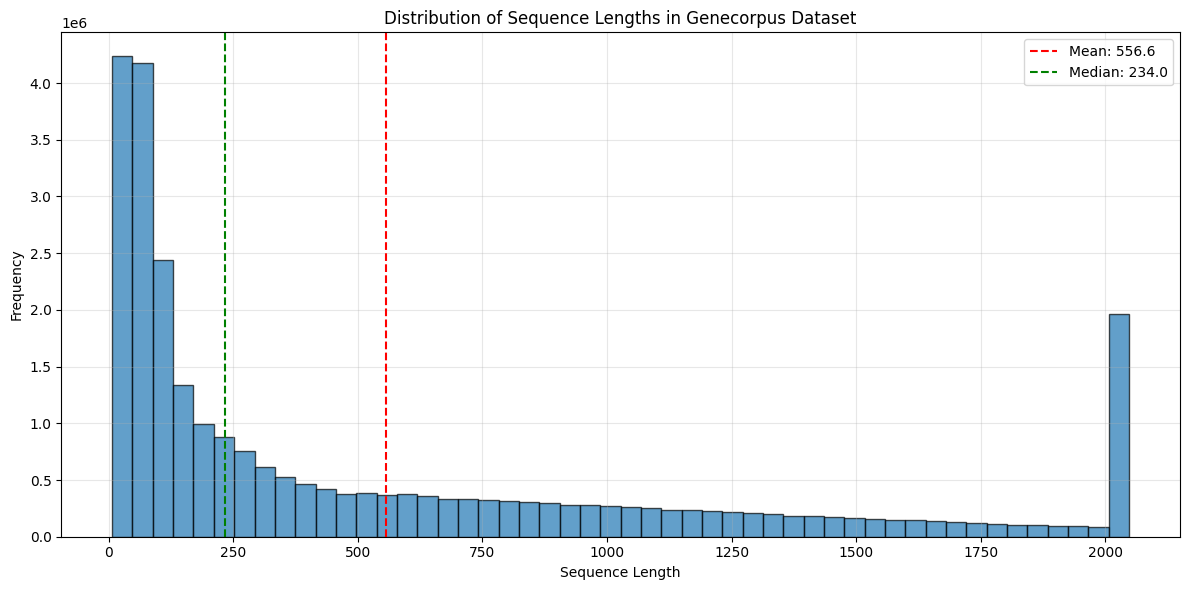

Sequence Length Statistics:
  Min: 7
  Max: 2048
  Mean: 556.56
  Median: 234.00
  Std Dev: 639.62
  25th percentile: 74.00
  75th percentile: 897.00
  95th percentile: 2048.00
  99th percentile: 2048.00


In [15]:
# Create histogram of sequence lengths
plt.figure(figsize=(12, 6))
plt.hist(lengths, bins=100, edgecolor='black', alpha=0.7)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths in Genecorpus Dataset')
plt.grid(True, alpha=0.3)

# Add statistics
mean_len = np.mean(lengths)
median_len = np.median(lengths)
max_len = np.max(lengths)
min_len = np.min(lengths)

plt.axvline(mean_len, color='red', linestyle='--', label=f'Mean: {mean_len:.1f}')
plt.axvline(median_len, color='green', linestyle='--', label=f'Median: {median_len:.1f}')
plt.legend()

plt.tight_layout()
plt.show()

# Print statistics
print(f"Sequence Length Statistics:")
print(f"  Min: {min_len}")
print(f"  Max: {max_len}")
print(f"  Mean: {mean_len:.2f}")
print(f"  Median: {median_len:.2f}")
print(f"  Std Dev: {np.std(lengths):.2f}")
print(f"  25th percentile: {np.percentile(lengths, 25):.2f}")
print(f"  75th percentile: {np.percentile(lengths, 75):.2f}")
print(f"  95th percentile: {np.percentile(lengths, 95):.2f}")
print(f"  99th percentile: {np.percentile(lengths, 99):.2f}")

In [9]:
total_computations = len(lengths) * (2048**2)
total_pad_computations = np.sum((2048 - np.array(lengths))**2)

print(f"Total computations without grouping: {total_computations:,}")
print(f"Total padding computations: {total_pad_computations:,}")
print(f"Padding overhead: {(total_pad_computations/total_computations)*100:.2f}%")

Total computations without grouping: 114,950,001,393,664
Total padding computations: 72,174,660,304,770
Padding overhead: 62.79%


So essentially 62.79% of the computation is being gone to the padding related computations. Haha, this neccessites the createion of length grouped sampler.

In [17]:
# Load the entire dataset folder
dataset_path = os.path.join(MAIN_PATH, "data/genecorpus_30M_2048.dataset")
ds = load_from_disk(dataset_path)

print("Dataset Info:")
print(f"Number of rows: {len(ds)}")
print(f"Columns: {ds.column_names}")
print(f"Features:\n{ds.features}")

print("\n\nFirst single example:")
pprint(ds[0], compact=True)

Dataset Info:
Number of rows: 27406216
Columns: ['input_ids', 'length']
Features:
{'input_ids': List(Value('int16')), 'length': Value('int16')}


First single example:
{'input_ids': [11143, 17261, 5368, 7411, 16411, 16337, 18754, 7055, 3906, 2109,
               10837, 8323, 1101, 6927, 18526, 2315, 9462, 3318, 3777, 12039,
               8877, 8008, 6840, 3932, 13443, 2359, 13693, 1823, 6533, 1981,
               16536, 11457, 18369, 15243, 13193, 17911, 5647, 2271, 14797,
               4326, 20334, 454, 10658, 17906, 11572, 955, 4163, 4422, 2786,
               8953, 15447, 14679, 10282, 13128, 11727, 16481, 17224, 1850,
               8462, 13590, 4703, 13569, 2961, 15255, 3101, 16472, 12926, 9724,
               20356, 3826, 3917, 5267, 1513, 15699, 3606, 9561, 6566, 5343,
               15937, 11938, 7203, 16990, 13620, 12437, 13643, 12040, 2100,
               13257, 5910, 576, 7502, 12324, 12636, 12460, 9220, 6423, 10863,
               5212, 13735, 24512, 4686, 2061, 5538, 479

Okay so they have given us the input id's and lengths and the data set is already tokenized and ranked we just need to figure out a way to just build a tokenizer which implements lengths grouped padding and distills the model. Just that not much. 

# int64 to int16

We are doing this conversion because all the values are under the limits of `int16`

from `int64` to `int16` we compress the data from around _120GB_ to _35GB_

In [16]:
# Simple int16 conversion
from datasets import Features, Value, Sequence

# Define int16 features
new_features = Features({
    'input_ids': Sequence(Value('int16')),
    'length': Value('int16')
})

# Convert dataset
print("Converting to int16...")
ds_int16 = ds.cast(new_features)

# Save
output_path = os.path.join(MAIN_PATH, "data/genecorpus_30M_2048_int16.dataset")
ds_int16.save_to_disk(output_path, num_shards=1)

print(f"Saved to: {output_path}")
print(f"Original: {ds.features}")
print(f"New: {ds_int16.features}")

Converting to int16...


Saving the dataset (1/1 shards): 100%|██████████| 27406216/27406216 [01:07<00:00, 406747.49 examples/s] 

✅ Saved to: /home/krrish/Desktop/Programming/geneformer-scratch/data/genecorpus_30M_2048_int16.dataset
Original: {'input_ids': List(Value('int64')), 'length': Value('int64')}
New: {'input_ids': List(Value('int16')), 'length': Value('int16')}


Done this the datasize has been shrunked from 120GB to 35GB but need to be wary about this in future programs because `nn.Embeddings` require for us to have `float32-64` so `int16` won't make the cut. So while passing to the model we need `.long()`. But now the data is workable with and `LengthGroupedSampler()` is really nice because it saves a lot of computation. 


In [15]:
model_path = "/home/krrish/Desktop/Programming/geneformer-scratch/models/geneformer-104M"
tokenizer_path = "ctheodoris/Geneformer"
model = BertForMaskedLM.from_pretrained(model_path)

In [11]:
model.eval()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(20275, 768, padding_idx=0)
      (position_embeddings): Embedding(4096, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

In [2]:
import pickle
v1_token_dict_path = "/home/krrish/Desktop/Programming/geneformer-scratch/src/data/tokenizer_data/V1/token_dictionary_gc30M.pkl"
v2_token_dict_path = "/home/krrish/Desktop/Programming/geneformer-scratch/src/data/tokenizer_data/V2/token_dictionary_gc104M.pkl"

In [3]:
with open(v1_token_dict_path, "rb") as f:
    v1_token_dict = pickle.load(f)
    
with open(v2_token_dict_path, "rb") as f:
    v2_token_dict = pickle.load(f)
    
len(v1_token_dict), len(v2_token_dict)

(25426, 20275)

In [4]:
v1_token_dict, v2_token_dict

({'<pad>': 0,
  '<mask>': 1,
  'ENSG00000000003': np.int16(2),
  'ENSG00000000005': np.int16(3),
  'ENSG00000000419': np.int16(4),
  'ENSG00000000457': np.int16(5),
  'ENSG00000000460': np.int16(6),
  'ENSG00000000938': np.int16(7),
  'ENSG00000000971': np.int16(8),
  'ENSG00000001036': np.int16(9),
  'ENSG00000001084': np.int16(10),
  'ENSG00000001167': np.int16(11),
  'ENSG00000001460': np.int16(12),
  'ENSG00000001461': np.int16(13),
  'ENSG00000001497': np.int16(14),
  'ENSG00000001561': np.int16(15),
  'ENSG00000001617': np.int16(16),
  'ENSG00000001626': np.int16(17),
  'ENSG00000001629': np.int16(18),
  'ENSG00000001630': np.int16(19),
  'ENSG00000001631': np.int16(20),
  'ENSG00000002016': np.int16(21),
  'ENSG00000002330': np.int16(22),
  'ENSG00000002549': np.int16(23),
  'ENSG00000002586': np.int16(24),
  'ENSG00000002587': np.int16(25),
  'ENSG00000002726': np.int16(26),
  'ENSG00000002745': np.int16(27),
  'ENSG00000002746': np.int16(28),
  'ENSG00000002822': np.int16(29),

In [6]:
v1_genes = set(v1_token_dict.keys())
v2_genes = set(v2_token_dict.keys())


# Unique to each
common_genes = v1_genes & v2_genes
v1_only = v1_genes - v2_genes
v2_only = v2_genes - v1_genes

In [11]:
len(v1_genes), len(v2_genes)

(25426, 20275)

In [7]:
len(common_genes), len(v1_only), len(v2_only)

(19625, 5801, 650)

This is one of the biggest problem to be honest. The vocab size mismatch and the unavailability of the 104Mn pretraining corpus of the gene data. Need to fall back to 10Mn param model for the distillation purposes.

In [10]:
data = load_from_disk("/home/krrish/Desktop/Programming/geneformer-scratch/mainData/genecorpus_30M_2048_int16.dataset")

In [12]:
data["length"]

Column([2048, 2048, 2048, 2048, 2048])

In [14]:
import sys
from pathlib import Path

project_root = Path.cwd().parent 
sys.path.insert(0, str(project_root))


In [15]:
from src.model.student_model import StudentModel

In [36]:
model = StudentModel(
    hidden_size=128,
    num_hidden_layers=3,
    num_attention_heads=4,
    intermediate_size = 512,
)

model.get_num_parameters()

4154065

Testing out how much time does it take.

In [6]:
# ✅ FIX: Use absolute path instead of relative
import sys
from pathlib import Path

# Use absolute path to project root
project_root = Path("/home/krrish/Desktop/Programming/geneformer-scratch")

print(f"Project root: {project_root}")
print(f"Project root exists: {project_root.exists()}")

# Add to Python path
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"✅ Python path updated")

# Verify src exists
src_path = project_root / "src"
print(f"'src' exists: {src_path.exists()}")
if src_path.exists():
    print(f"Contents of src: {list(src_path.iterdir())}")

Project root: /home/krrish/Desktop/Programming/geneformer-scratch
Project root exists: True
✅ Python path updated
'src' exists: True
Contents of src: [PosixPath('/home/krrish/Desktop/Programming/geneformer-scratch/src/training'), PosixPath('/home/krrish/Desktop/Programming/geneformer-scratch/src/model'), PosixPath('/home/krrish/Desktop/Programming/geneformer-scratch/src/data'), PosixPath('/home/krrish/Desktop/Programming/geneformer-scratch/src/__pycache__'), PosixPath('/home/krrish/Desktop/Programming/geneformer-scratch/src/__init__.py'), PosixPath('/home/krrish/Desktop/Programming/geneformer-scratch/src/main.py')]


In [7]:
from src.data.dataset import GeneformerDataset
import torch

dataset = GeneformerDataset("/home/krrish/Desktop/Programming/geneformer-scratch/mainData/genecorpus_30M_2048_int16.dataset")

In [8]:
trainds, val_ds = dataset.split(
    split_ratio=0.9999
)

In [11]:
trainds.lengths

array([886,  88,  17, ...,  90,  90, 196], shape=(27403475,))

In [12]:
from transformers.trainer_pt_utils import LengthGroupedSampler

In [13]:
sampler = LengthGroupedSampler(
    batch_size=8,
    lengths=trainds.lengths,
    dataset=trainds
)

In [25]:
train_loader = torch.utils.data.DataLoader(
    trainds,
    batch_size=8,
    sampler=sampler,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    prefetch_factor=2,
)

train_loader  = iter(train_loader)

In [31]:
batch = next(train_loader)

In [33]:
input_ids = batch['input_ids']
lengths = batch['length']

print(input_ids)
print(lengths)

[tensor([  454,  1720,  8531, 23522,  1932, 17869,  4552, 10862]), tensor([22562, 10390,  7723,  7247, 10824,  4493,  4598, 19899]), tensor([ 3584,  9816,  8425,  9245,  4399, 19788, 12930, 16909]), tensor([ 9945, 17905,  8323,  4853,  7111,  4345,  4456,  1720]), tensor([ 7055,  7975, 11936,  9461,  9067,  1720,  7764, 17660]), tensor([13744,  2992, 18526, 23807,  1279,  2053, 17626, 19629]), tensor([20334,  6000, 11707, 10009,  5095, 18489, 17625,  3705]), tensor([ 1806, 14816,   377, 12509,   454, 11038,   848, 15937]), tensor([10600, 10744, 20268, 11434,  6196,  4285, 18488, 17451]), tensor([ 1147,  6198, 13797,  4536,  8132, 12518, 15396,  6179]), tensor([ 7204, 12017,  7410,  1203,  9889,  1312,  4717, 20151]), tensor([ 2183, 19968,  5557,  9357, 18367, 11592,  2061, 12509]), tensor([ 7359,  7892, 15345,  9969,  2886, 12792,  7352,  8522]), tensor([ 5246, 11463,  3088,   396,   676, 11050,  1513,  3852]), tensor([ 8953,  8229,  4038, 13343, 25367,  8601,  8981,  6303]), tensor([ 

There is something fundamentally wrong, it is giving only 8 input ids. Need to check this out tomorrow. 